# CVAE

In this notebook, we will test the Conditional Variational Autoencoder implementation from `cvae.py` on the MNIST dataset.

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook. Let's start by checking whether we are using Python 3.10 or higher.

Note: You may run your code on Google Colab if you'd like because training a CVAE might take some time. However, colab uses Python 3.8, where our autograder uses 3.10. Your output is unlikely to differ by much, but this is a heads up.

In [2]:
import sys
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3")

if sys.version_info[1] < 11:
    print("Autograder will execute your code based on Python 3.11 environment. Please use Python 3.11 or higher to prevent any issues")
    print("You can create a conda environment with Python 3.11 like 'conda create --name eecs545 python=3.11'")
    raise Exception("Python 3 version is too low: {}".format(sys.version))
else:
    print("You are good to go")

You are good to go


First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [3]:
%load_ext autoreload
%autoreload 2

Then, we run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [4]:
# install required libraries
!pip install numpy matplotlib

# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# set figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Next, we need to make sure pytorch is installed. The following command will install pytorch if you haven't installed it before. Depending on your OS and GPU hardware, this may install a CPU or GPU version. If you want to use a GPU with PyTorch (which will exponentially speed up your computation time) you can follow the instructions on the pytorch [official website](https://pytorch.org/get-started/locally/). In this problem set a CPU-only pytorch is sufficient.

Google Colab is also an option to run your code on the cloud with a CUDA GPU. However, you will need to use a slightly different python version.

In [5]:
!pip install torch torchvision

In [6]:
import torch
# check if CUDA is available on torch
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? False


In [7]:
from IPython.display import display_html, HTML

display_html(HTML('''
<style type="text/css">
  .instruction { background-color: yellow; font-weight:bold; padding: 3px; }
</style>
'''));

Running the following cell allow us to import from `cvae.py`. If it works correctly, it should print the message:
```Hello from cvae.py!```.

In [8]:
import cvae
cvae.hello()

Hello from cvae.py!


## Loading the dataset

In [9]:
import torch
import torch.utils.data
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()  # we will use cuda only if it is available
batch_size = 32

# Load MNIST dataset
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
dataset = datasets.MNIST(
    './data', train=True, download=True,
    transform=transforms.ToTensor())
train_dataset = torch.utils.data.Subset(dataset, indices=range(10000))
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

## Hyperparameters

We will set the following as our hyperparameters.

In [10]:
input_size = 28 * 28
hidden_units = 400
latent_size = 20  # z dim
num_classes = 10
num_epochs = 10
learning_rate = 1e-3

## Loading the model

In [11]:
model = cvae.CVAE(
    input_size=input_size,
    latent_size=latent_size,
    num_classes=num_classes,
    hidden_units=hidden_units,
)
if use_cuda:
    model.cuda()  # convert the model to cuda if use_cuda

In [12]:
# Visualizing the model layers
print(model)

CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU()
  )
  (mu_layer): Linear(in_features=410, out_features=20, bias=True)
  (logvar_layer): Linear(in_features=410, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=784, bias=True)
    (7): Sigmoid()
    (8): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)


## Training!

We will now train our model with the Adam optimizer. Without a GPU, this will take around 5 minutes.

In [13]:
%%time
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(1, num_epochs+1):
    cvae.train(epoch, model, train_loader, optimizer, num_classes, use_cuda)

Train Epoch: 1 [0/10000 (0%)]	Loss: 543.916199
Train Epoch: 1 [3200/10000 (32%)]	Loss: 194.292618
Train Epoch: 1 [6400/10000 (64%)]	Loss: 191.958603
Train Epoch: 1 [9600/10000 (96%)]	Loss: 185.746216
Train Epoch: 2 [0/10000 (0%)]	Loss: 159.498001
Train Epoch: 2 [3200/10000 (32%)]	Loss: 156.181900
Train Epoch: 2 [6400/10000 (64%)]	Loss: 151.471375
Train Epoch: 2 [9600/10000 (96%)]	Loss: 154.883087
Train Epoch: 3 [0/10000 (0%)]	Loss: 160.628189
Train Epoch: 3 [3200/10000 (32%)]	Loss: 144.494812
Train Epoch: 3 [6400/10000 (64%)]	Loss: 134.506973
Train Epoch: 3 [9600/10000 (96%)]	Loss: 125.343384
Train Epoch: 4 [0/10000 (0%)]	Loss: 143.216904
Train Epoch: 4 [3200/10000 (32%)]	Loss: 138.994171
Train Epoch: 4 [6400/10000 (64%)]	Loss: 141.997421
Train Epoch: 4 [9600/10000 (96%)]	Loss: 168.462875
Train Epoch: 5 [0/10000 (0%)]	Loss: 139.299210
Train Epoch: 5 [3200/10000 (32%)]	Loss: 140.363541
Train Epoch: 5 [6400/10000 (64%)]	Loss: 125.049255
Train Epoch: 5 [9600/10000 (96%)]	Loss: 128.090240


## Generating images with condition labels

In [14]:
# Generate images with condition labels
n_samples = 100
c = torch.eye(num_classes)[torch.arange(n_samples) % num_classes] # [one hot labels for 0-9]
c = cvae.to_var(c, use_cuda)
z = cvae.to_var(torch.randn(n_samples, latent_size), use_cuda)
samples = model.generation_model(z, c).data.cpu().numpy()

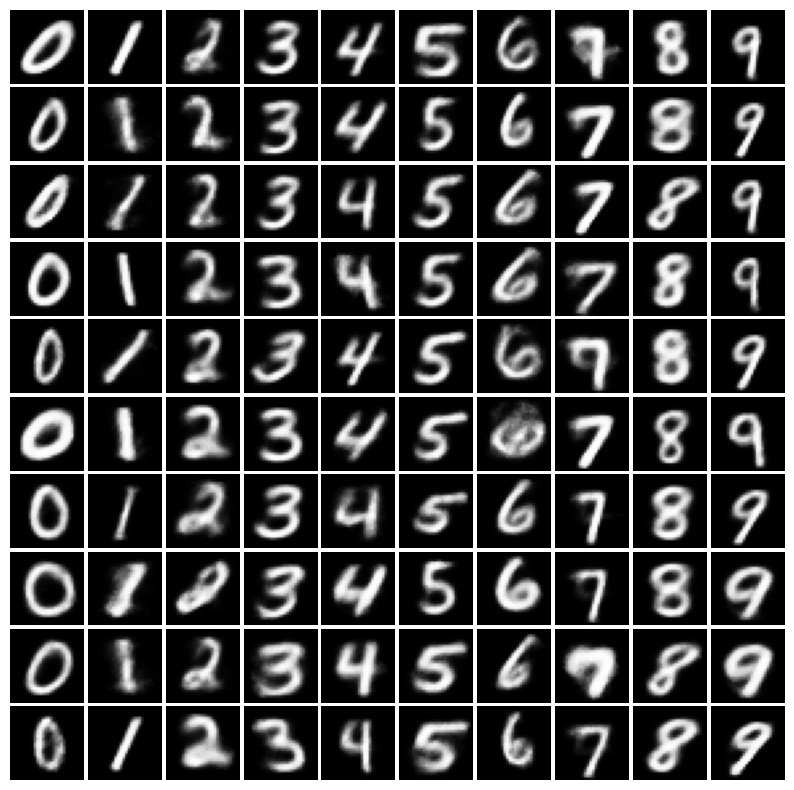

In [15]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(num_classes, n_samples // num_classes))
gs = gridspec.GridSpec(n_samples // num_classes, num_classes)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])  # type: ignore
    ax.set_yticklabels([])  # type: ignore
    ax.set_aspect('equal')  # type: ignore
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.show()

What do you see? We expect to see some handwritten digits similar to samples in MNIST! However they are not perfect, some of them are blurred.